##### Copyright 2020 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 通过 JAX 进行分布式推断

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/probability/examples/Distributed_Inference_with_JAX"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org上查看</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Distributed_Inference_with_JAX.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 运行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Distributed_Inference_with_JAX.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/probability/examples/Distributed_Inference_with_JAX.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

JAX 上的 TensorFlow Probability (TFP) 现在具有分布式数值计算工具。为了扩展到大量加速器，这些工具围绕使用“单程序多数据”（简称 SPMD）范式编写代码而构建。

在本笔记本中，我们将说明如何“以 SPMD 的方式思考”，并介绍用于扩展到 TPU pod 或 GPU 集群等配置的新 TFP 抽象。如果您自己运行此代码，请确保选择 TPU 运行时。

我们先安装最新版本的 TFP、JAX 和 TF。

In [ ]:
#@title Installs
!pip install jaxlib --upgrade -q 2>&1 1> /dev/null
!pip install tfp-nightly[jax] --upgrade -q 2>&1 1> /dev/null
!pip install tf-nightly-cpu -q -I 2>&1 1> /dev/null
!pip install jax -I -q --upgrade 2>&1 1>/dev/null

ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: tf-nightly-cpu 2.6.0.dev20210401 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR:

我们将导入一些通用库以及一些 JAX 实用程序。

In [ ]:
#@title Setup and Imports
import functools
import collections
import contextlib

import jax
import jax.numpy as jnp
from jax import lax
from jax import random
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow_datasets as tfds

from tensorflow_probability.substrates import jax as tfp

sns.set(style='white')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


我们还将设置一些方便的 TFP 别名。新的抽象目前在 `tfp.experimental.distribute` 和 `tfp.experimental.mcmc` 中提供。

In [ ]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfm = tfp.mcmc
tfed = tfp.experimental.distribute
tfde = tfp.experimental.distributions
tfem = tfp.experimental.mcmc

Root = tfed.JointDistributionCoroutine.Root

为了将笔记本连接到 TPU，我们使用 JAX 中的以下辅助程序。为了确认已经连接，我们打印出设备数量，应该为 8。

In [ ]:
from jax.tools import colab_tpu
colab_tpu.setup_tpu()
print(f'Found {jax.device_count()} devices')

Found 8 devices


# `jax.pmap` 快速简介

连接到 TPU 后，我们可以访问 *8* 台设备。但是，当我们迫不及待地运行 JAX 代码时，JAX 默认只能在一台设备上运行计算。

在多台设备上执行计算的最简单方法是映射一个函数，让每台设备执行映射的一个索引。JAX 提供了 `jax.pmap`（“并行映射”）转换，可将一个函数转换为在多个设备上映射该函数的另一个函数。

在下面的示例中，我们创建一个大小为 8 的数组（匹配可用设备的数量）并映射一个在其上加 5 的函数。

In [ ]:
xs = jnp.arange(8.)
out = jax.pmap(lambda x: x + 5.)(xs)
print(type(out), out)

<class 'jax.interpreters.pxla.ShardedDeviceArray'> [ 5.  6.  7.  8.  9. 10. 11. 12.]


请注意，我们收到一个 `ShardedDeviceArray` 类型，表明输出数组在物理上是拆分到多个设备的。

`jax.pmap` 在语义上与映射类似，但有几个重要的选项会修改其行为。默认情况下，`pmap` 假定函数的所有输入都将被映射，但我们可以通过 `in_axes` 参数修改此行为。

In [ ]:
xs = jnp.arange(8.)
y = 5.
# Map over the 0-axis of `xs` and don't map over `y`
out = jax.pmap(lambda x, y: x + y, in_axes=(0, None))(xs, y)
print(out)

[ 5.  6.  7.  8.  9. 10. 11. 12.]


类似地，`pmap` 的 `out_axes` 参数决定了是否在每个设备上都返回值。将 `out_axes` 设置为 `None` 会自动在第一个设备上返回值，只有我们确信每个设备上的值都相同时才应该这样使用。

In [ ]:
xs = jnp.ones(8) # Value is the same on each device
out = jax.pmap(lambda x: x + 1, out_axes=None)(xs)
print(out)

2.0


当我们想做的事情不容易表示为映射的纯函数时，会发生什么？例如，如果我们想在映射到的轴上求和，该怎么办？JAX 提供了“集合”，即跨设备通信的功能，以支持编写更有趣和更复杂的分布式程序。为了了解它们的工作原理，我们将介绍 SPMD。

# 什么是 SPMD？

单程序多数据 (SPMD) 是一种并发编程模型，在该模型中，多个设备可同时执行单个程序（即相同代码），但每个运行的程序的输入都可以不同。

如果我们的程序是其输入的简单函数（例如类似于 `x + 5`），那么在 SPMD 中运行程序只是将其映射到不同的数据上，就像我们使用 `jax.pmap` 进行的操作。然而，我们可以做的不仅仅是“映射”一个函数。JAX 提供了“集合”，即跨设备通信的功能。

例如，我们可能想计算所有设备的数量。在此之前，我们需要为在 `pmap` 中映射的轴指定一个名称。然后，我们使用 `lax.psum`（“并行求和”）函数执行跨设备求和，确保我们识别将对其求和的指定轴。

In [ ]:
def f(x):
  out = lax.psum(x, axis_name='i')
  return out
xs = jnp.arange(8.) # Length of array matches number of devices
jax.pmap(f, axis_name='i')(xs)

ShardedDeviceArray([28., 28., 28., 28., 28., 28., 28., 28.], dtype=float32)

`psum` 集合会聚合每个设备上的 `x` 值并在映射中同步其值，即每个设备上的 `out` 为 `28`。我们不再执行简单的“映射”，而是执行 SPMD 程序，其中每个设备的计算现在可以与其他设备上的相同计算进行交互，尽管使用集合的方式受限。在这种情况下，我们可以使用 `out_axes = None`，因为 `psum` 将同步值。

In [ ]:
def f(x):
  out = lax.psum(x, axis_name='i')
  return out
jax.pmap(f, axis_name='i', out_axes=None)(jnp.arange(8.))

ShardedDeviceArray(28., dtype=float32)

SPMD 让我们能够编写一个可以同时在每个设备上运行的程序，不管设备的 TPU 配置如何。用于在 8 个 TPU 内核上进行机器学习的相同代码也可以在可能具有数百到数千个内核的 TPU pod 上使用！有关 `jax.pmap` 和 SPMD 的更详细教程，可以参阅 [JAX 101 教程](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html)。

# 大规模 MCMC

在本笔记本中，我们重点使用马尔可夫链蒙特卡罗 (MCMC) 方法进行贝叶斯推断。我们可以通过多种方式将多个设备用于 MCMC，但在本笔记本中，我们将重点介绍两种方式：

1. 在不同的设备上运行独立的马尔可夫链。这种方式相当简单，可以使用普通 TFP 实现。
2. 将数据集分片在多个设备上。这种方式更复杂一些，需要最近添加的 TFP 机制。

## 独立链

假设我们想使用 MCMC 对一个问题进行贝叶斯推断，并且想在多个设备上并行运行多个链（假设每个设备上 2 个链）。事实证明，这是一个我们可以跨设备“映射”的程序，即不需要集合的程序。为了确保每个程序都执行不同的马尔可夫链（而不是运行同一个链），我们将不同的随机种子值传递给每个设备。

让我们在一个从 2-D 高斯分布采样的玩具问题上尝试一下。我们可以使用 TFP 开箱即用的现有 MCMC 功能。通常，我们设法将大部分逻辑放在映射的函数内，以便更明确地区分在所有设备上运行的内容与仅在第一个设备上运行的内容。

In [ ]:
def run(seed):
  target_log_prob = tfd.Sample(tfd.Normal(0., 1.), 2).log_prob

  initial_state = jnp.zeros([2, 2]) # 2 chains
  kernel = tfm.HamiltonianMonteCarlo(target_log_prob, 1e-1, 10)
  def trace_fn(state, pkr):
    return target_log_prob(state)

  states, log_prob = tfm.sample_chain(
    num_results=1000,
    num_burnin_steps=1000,
    kernel=kernel,
    current_state=initial_state,
    trace_fn=trace_fn,
    seed=seed
  )
  return states, log_prob

`run` 函数本身接受无状态随机种子（要了解无状态随机性的原理，您可以阅读 [JAX 上的 TFP](https://tensorflow.google.cn/probability/examples/TensorFlow_Probability_on_JAX) 笔记本或查看 [JAX 101 教程](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html)）。将 `run` 映射到不同的种子将导致运行多个独立的马尔可夫链。

In [ ]:
states, log_probs = jax.pmap(run)(random.split(random.PRNGKey(0), 8))
print(states.shape, log_probs.shape)
# states is (8 devices, 1000 samples, 2 chains, 2 dimensions)
# log_prob is (8 devices, 1000 samples, 2 chains)

(8, 1000, 2, 2) (8, 1000, 2)


请注意，现在对于每个设备，都有一个额外的轴相对应。我们可以重新排列维度并将它们展平，以获得 16 个链的轴。

In [ ]:
states = states.transpose([0, 2, 1, 3]).reshape([-1, 1000, 2])
log_probs = log_probs.transpose([0, 2, 1]).reshape([-1, 1000])

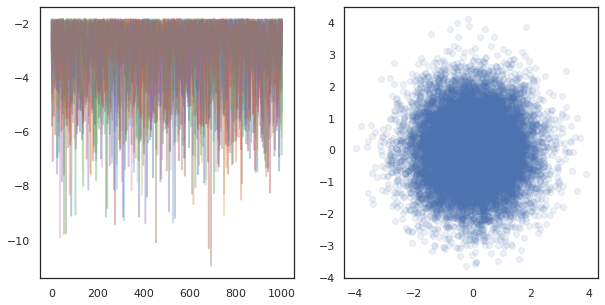

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(log_probs.T, alpha=0.4)
ax[1].scatter(*states.reshape([-1, 2]).T, alpha=0.1)
plt.show()

在多个设备上运行独立的链时，就像对使用 `tfp.mcmc` 的函数进行 `pmap` 一样简单，确保我们将不同的随机种子值传递给每个设备。

## 分片数据

进行 MCMC 时，目标分布通常是通过对数据集进行调节而获得的后验分布，并且计算非归一化对数密度涉及到将每个观测数据的概率相加。

对于非常大的数据集，即使在单个设备上运行一个链也可能代价高昂。但是，当我们可以访问多个设备时，我们可以将数据集拆分到多个设备上，更好地利用我们可用的计算能力。

如果我们要使用分片数据集进行 MCMC，我们需要确保在每个设备上计算的非归一化对数密度都代表*总体*，即所有数据的密度，否则每个设备将使用各自不正确的目标分布进行 MCMC。为此，TFP 现在有了新工具（即 `tfp.experimental.distribute` 和 `tfp.experimental.mcmc`）来计算“分片的”对数概率并使用它们进行 MCMC。

### 分片分布

现在，TFP 为计算分片对数概率提供的核心抽象是 `Sharded` 元分布，它将分布作为输入，并返回一个新分布，该分布在 SPMD 上下文中执行时具有特定属性。`Sharded` 位于 `tfp.experimental.distribute` 中。

直观上，`Sharded` 分布对应于一组随机变量，这些变量已“拆分”到多个设备上。在每个设备上，它们会生成不同的样本，并且可以分别具有不同的对数密度。或者，`Sharded` 分布对应于图形模型用语中的“盘”(plate)，其中盘大小是设备的数量。


#### 对 `Sharded` 分布进行采样

如果我们在每个设备上使用相同的种子从被 `pmap` 的程序中的 `Normal` 分布采样，我们将在每个设备上获得相同的样本。我们可以将以下函数视为对跨设备同步的单个随机变量进行采样。

In [ ]:
# `pmap` expects at least one value to be mapped over, so we provide a dummy one
def f(seed, _):
  return tfd.Normal(0., 1.).sample(seed=seed)
jax.pmap(f, in_axes=(None, 0))(random.PRNGKey(0), jnp.arange(8.))

ShardedDeviceArray([-0.20584236, -0.20584236, -0.20584236, -0.20584236,
                    -0.20584236, -0.20584236, -0.20584236, -0.20584236],                   dtype=float32)

如果我们用 `tfed.Sharded` 包装 `tfd.Normal(0., 1.)`，逻辑上我们现在有八个不同的随机变量（每个设备上一个），因此尽管传入相同的种子，但将为每个变量生成不同的样本。

In [ ]:
def f(seed, _):
  return tfed.Sharded(tfd.Normal(0., 1.), shard_axis_name='i').sample(seed=seed)
jax.pmap(f, in_axes=(None, 0), axis_name='i')(random.PRNGKey(0), jnp.arange(8.))

ShardedDeviceArray([ 1.2152631 ,  0.7818249 ,  0.32549605,  0.6828047 ,
                     1.3973192 , -0.57830244,  0.37862757,  2.7706041 ],                   dtype=float32)

此分布在单个设备上的等效表示只是 8 个独立的正态样本。尽管样本的值会有所不同（`tfed.Sharded` 生成伪随机数的方式略有不同），但它们都代表相同的分布。

In [ ]:
dist = tfd.Sample(tfd.Normal(0., 1.), jax.device_count())
dist.sample(seed=random.PRNGKey(0))

DeviceArray([ 0.08086783, -0.38624594, -0.3756545 ,  1.668957  ,
             -1.2758069 ,  2.1192007 , -0.85821325,  1.1305912 ],            dtype=float32)

#### 获取 `Sharded` 分布的对数密度

我们看一下在 SPMD 上下文中根据正则分布计算样本的对数密度时会发生什么。

In [ ]:
def f(seed, _):
  dist = tfd.Normal(0., 1.)
  x = dist.sample(seed=seed)
  return x, dist.log_prob(x)
jax.pmap(f, in_axes=(None, 0))(random.PRNGKey(0), jnp.arange(8.))

(ShardedDeviceArray([-0.20584236, -0.20584236, -0.20584236, -0.20584236,
                     -0.20584236, -0.20584236, -0.20584236, -0.20584236],                   dtype=float32),
 ShardedDeviceArray([-0.94012403, -0.94012403, -0.94012403, -0.94012403,
                     -0.94012403, -0.94012403, -0.94012403, -0.94012403],                   dtype=float32))

每个设备上的每个样本都是相同的，因此我们也在每个设备上计算相同的密度。直观上看，我们只有一个正态分布变量的分布。

对于 `Sharded` 分布，我们有一个超过 8 个随机变量的分布，因此当我们计算样本的 `log_prob` 时，我们会跨设备将每个单独的日志密度相加。（您可能会注意到，这个总的 log_prob 值大于上面计算的单个 log_prob。）

In [ ]:
def f(seed, _):
  dist = tfed.Sharded(tfd.Normal(0., 1.), shard_axis_name='i')
  x = dist.sample(seed=seed)
  return x, dist.log_prob(x)
sample, log_prob = jax.pmap(f, in_axes=(None, 0), axis_name='i')(
    random.PRNGKey(0), jnp.arange(8.))
print('Sample:', sample)
print('Log Prob:', log_prob)

Sample: [ 1.2152631   0.7818249   0.32549605  0.6828047   1.3973192  -0.57830244
  0.37862757  2.7706041 ]
Log Prob: [-13.7349205 -13.7349205 -13.7349205 -13.7349205 -13.7349205 -13.7349205
 -13.7349205 -13.7349205]


等效的“未分片”分布产生相同的对数密度。

In [ ]:
dist = tfd.Sample(tfd.Normal(0., 1.), jax.device_count())
dist.log_prob(sample)

DeviceArray(-13.7349205, dtype=float32)

`Sharded` 分布从每个设备上的 `sample` 产生不同的值，但针对每个设备上的 `log_prob` 产生相同的值。这是怎么回事？`Sharded` 分布在内部执行 `psum` 以确保 `log_prob` 值在各设备间同步。为什么我们需要这种行为？如果我们在每个设备上运行*相同*的 MCMC 链，我们希望 `target_log_prob` 在每个设备上都相同，即使计算中的一些随机变量在设备之间分片。

此外，`Sharded` 分布确保跨设备的梯度是正确的，以确保 HMC 之类的算法（将对数密度函数的梯度作为转换函数的一部分）产生正确的样本。

### 分片的 `JointDistribution`

我们可以使用 `JointDistribution` (JD) 创建具有多个 `Sharded` 随机变量的模型。不幸的是，`Sharded` 分布不能安全地与普通 `tfd.JointDistribution` 一起使用，但 `tfp.experimental.distribute` 可导出“打过补丁”的 JD，其行为类似于 `Sharded` 分布。

In [ ]:
def f(seed, _):
  dist = tfed.JointDistributionSequential([
    tfd.Normal(0., 1.),
    tfed.Sharded(tfd.Normal(0., 1.), shard_axis_name='i'),
  ])
  x = dist.sample(seed=seed)
  return x, dist.log_prob(x)
jax.pmap(f, in_axes=(None, 0), axis_name='i')(random.PRNGKey(0), jnp.arange(8.))

([ShardedDeviceArray([1.6121525, 1.6121525, 1.6121525, 1.6121525, 1.6121525,
                      1.6121525, 1.6121525, 1.6121525], dtype=float32),
  ShardedDeviceArray([ 0.8690128 , -0.83167845,  1.2209264 ,  0.88412696,
                       0.76478404, -0.66208494, -0.0129658 ,  0.7391483 ],                   dtype=float32)],
 ShardedDeviceArray([-12.214451, -12.214451, -12.214451, -12.214451,
                     -12.214451, -12.214451, -12.214451, -12.214451],                   dtype=float32))

这些分片的 JD 可以将 `Sharded` 和普通 TFP 分布作为组件。对于非分片分布，我们在每个设备上获得相同的样本，而对于分片分布，我们获得不同的样本。每个设备上的 `log_prob` 也是同步的。

### MCMC 与 `Sharded` 分布

在 MCMC 的上下文中，我们如何看待 `Sharded` 分布？如果我们有一个可以用 `JointDistribution` 表示的生成模型，我们可以选择该模型的某个轴来进行“分片”。通常，模型中的一个随机变量将对应于观测的数据，如果我们有一个要分片到多个设备上的大型数据集，我们希望与数据点关联的变量也被分片。我们还可能有“局部”随机变量，它们与我们要分片的观测结果是一对一的关系，因此我们必须另外分片这些随机变量。

在本节中，我们将介绍将 `Sharded`分布与 TFP MCMC 一起使用的示例。我们将从一个较为简单的贝叶斯逻辑回归示例开始，以一个矩阵分解示例结束，目的是演示 `distribute` 库的一些用例。


##### 示例：面向 MNIST 的贝叶斯逻辑回归

我们想要对一个大型数据集进行贝叶斯逻辑回归；该模型在回归权重上有一个先验 $p(\theta)$，以及对所有数据 ${x_i, y_i}_{i = 1}^N$ 求和的似然 $p(y_i | \theta, x_i)$，以获得总的联合对数密度。如果我们对数据进行分片，我们会对在模型中观测到的随机变量 $x_i$ 和 $y_i$ 分片。 

我们使用以下贝叶斯逻辑回归模型进行 MNIST 分类：$$ \begin{align*} w &amp;\sim \mathcal{N}(0, 1) \ b &amp;\sim \mathcal{N}(0, 1) \ y_i | w, b, x_i &amp;\sim \textrm{Categorical}(w^T x_i + b) \end{align*} $$

让我们使用 TensorFlow 数据集加载 MNIST。

In [ ]:
mnist = tfds.as_numpy(tfds.load('mnist', batch_size=-1))
raw_train_images, train_labels = mnist['train']['image'], mnist['train']['label']
train_images = raw_train_images.reshape([raw_train_images.shape[0], -1]) / 255.

raw_test_images, test_labels = mnist['test']['image'], mnist['test']['label']
test_images = raw_test_images.reshape([raw_test_images.shape[0], -1]) / 255.

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


我们有 60000 个训练图像，但让我们利用 8 个可用核心并将其分为 8 个部分。我们将使用这个方便的 `shard` 实用函数。

In [ ]:
def shard_value(x):
  x = x.reshape((jax.device_count(), -1, *x.shape[1:]))
  return jax.pmap(lambda x: x)(x) # pmap will physically place values on devices

shard = functools.partial(jax.tree_map, shard_value)

In [ ]:
sharded_train_images, sharded_train_labels = shard((train_images, train_labels))
print(sharded_train_images.shape, sharded_train_labels.shape)

(8, 7500, 784) (8, 7500)


在继续之前，让我们快速讨论一下 TPU 的精度及其对 HMC 的影响。TPU 使用低 `bfloat16` 精度执行矩阵乘法以提高速度。`bfloat16` 矩阵乘法对于许多深度学习应用通常已经足够，但与 HMC 一起使用时，我们根据经验发现，较低的精度可能导致发散的轨迹，进而导致拒绝。我们可以使用更高精度的矩阵乘法，但代价是一些额外的计算。

为了提高 matmul 精度，我们可以使用具有 `"tensorfloat32"` 精度的 `jax.default_matmul_precision` 修饰器（要获得更高的精度，我们可以使用 `"float32"` 精度）。

现在我们来定义 `run` 函数，它将接受一个随机种子（在每个设备上都是相同的）和一个 MNIST 分片。该函数将实现上述模型，然后我们将使用 TFP 的普通 MCMC 功能来运行单个链。我们将确保使用 `jax.default_matmul_precision` 修饰器来修饰 `run`，以确保矩阵乘法以更高的精度运行，尽管在下面的特定示例中，我们也可以使用 `jnp.dot(images, w, precision=lax.Precision.HIGH)`。

In [ ]:
# We can use `out_axes=None` in the `pmap` because the results will be the same
# on every device. 
@functools.partial(jax.pmap, axis_name='data', in_axes=(None, 0), out_axes=None)
@jax.default_matmul_precision('tensorfloat32')
def run(seed, data):
  images, labels = data # a sharded dataset
  num_examples, dim = images.shape
  num_classes = 10

  def model_fn():
    w = yield Root(tfd.Sample(tfd.Normal(0., 1.), [dim, num_classes]))
    b = yield Root(tfd.Sample(tfd.Normal(0., 1.), [num_classes]))
    logits = jnp.dot(images, w) + b
    yield tfed.Sharded(tfd.Independent(tfd.Categorical(logits=logits), 1),
                       shard_axis_name='data')
  model = tfed.JointDistributionCoroutine(model_fn)

  init_seed, sample_seed = random.split(seed)

  initial_state = model.sample(seed=init_seed)[:-1] # throw away `y`

  def target_log_prob(*state):
    return model.log_prob((*state, labels))

  def accuracy(w, b):
    logits = images.dot(w) + b
    preds = logits.argmax(axis=-1)
    # We take the average accuracy across devices by using `lax.pmean`
    return lax.pmean((preds == labels).mean(), 'data')

  kernel = tfm.HamiltonianMonteCarlo(target_log_prob, 1e-2, 100)
  kernel = tfm.DualAveragingStepSizeAdaptation(kernel, 500)
  def trace_fn(state, pkr):
    return (
        target_log_prob(*state),
        accuracy(*state),
        pkr.new_step_size)
  states, trace = tfm.sample_chain(
    num_results=1000,
    num_burnin_steps=1000,
    current_state=initial_state,
    kernel=kernel,
    trace_fn=trace_fn,
    seed=sample_seed
  )
  return states, trace

`jax.pmap` 包含一个 JIT 编译，但编译后的函数在第一次调用后被缓存。我们将调用 `run` 并忽略输出以缓存编译。

In [ ]:
%%time
output = run(random.PRNGKey(0), (sharded_train_images, sharded_train_labels))
jax.tree_map(lambda x: x.block_until_ready(), output)

CPU times: user 24.5 s, sys: 48.2 s, total: 1min 12s
Wall time: 1min 54s


我们现在将再次调用 `run` 来查看实际执行所需的时间。

In [ ]:
%%time
states, trace = run(random.PRNGKey(0), (sharded_train_images, sharded_train_labels))
jax.tree_map(lambda x: x.block_until_ready(), trace)

CPU times: user 13.1 s, sys: 45.2 s, total: 58.3 s
Wall time: 1min 43s


我们将执行 200,000 次蛙跳步骤，每个步骤都计算整个数据集的梯度。将计算拆分到 8 个核心使我们能够在大约 95 秒内计算相当于 200,000 个训练周期，大约每秒 2,100 个周期！

让我们绘制每个样本的对数密度和每个样本的准确率：

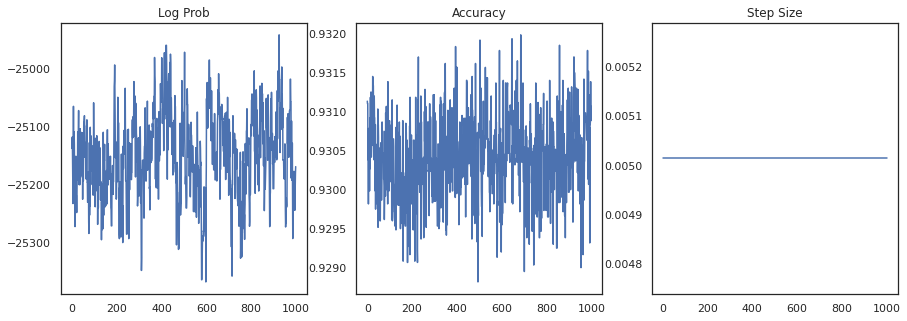

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(trace[0])
ax[0].set_title('Log Prob')
ax[1].plot(trace[1])
ax[1].set_title('Accuracy')
ax[2].plot(trace[2])
ax[2].set_title('Step Size')
plt.show()

如果我们对样本进行集成，我们可以计算贝叶斯模型平均值来提高性能。

In [ ]:
@functools.partial(jax.pmap, axis_name='data', in_axes=(0, None), out_axes=None)
def bayesian_model_average(data, states):
  images, labels = data
  logits = jax.vmap(lambda w, b: images.dot(w) + b)(*states)
  probs = jax.nn.softmax(logits, axis=-1)
  bma_accuracy = (probs.mean(axis=0).argmax(axis=-1) == labels).mean()
  avg_accuracy = (probs.argmax(axis=-1) == labels).mean()
  return lax.pmean(bma_accuracy, axis_name='data'), lax.pmean(avg_accuracy, axis_name='data')

sharded_test_images, sharded_test_labels = shard((test_images, test_labels))
bma_acc, avg_acc = bayesian_model_average((sharded_test_images, sharded_test_labels), states)
print(f'Average Accuracy: {avg_acc}')
print(f'BMA Accuracy: {bma_acc}')
print(f'Accuracy Improvement: {bma_acc - avg_acc}')

Average Accuracy: 0.9188529253005981
BMA Accuracy: 0.9264000058174133
Accuracy Improvement: 0.0075470805168151855


贝叶斯模型平均值将准确率提高了近 1%！

##### 示例：MovieLens 推荐系统

我们现在尝试使用 MovieLens 推荐数据集进行推断，该数据集是用户及其对各种电影的评分的集合。具体来说，我们可以将 MovieLens 表示为 $N \times M$ 观看矩阵 $W$，其中 $N$ 是用户数量，$M$ 是电影数量；我们期望 $N &gt; M$。$W_{ij}$ 的条目是一个布尔值，指示用户 $i$ 是否观看了电影 $j$。请注意，MovieLens 提供了用户评分，但我们将忽略它们以简化问题。

首先，我们将加载数据集。我们将使用具有 100 万个评分的版本。

In [ ]:
movielens = tfds.as_numpy(tfds.load('movielens/1m-ratings', batch_size=-1))
GENRES = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
          'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
          'Thriller', 'Unknown', 'War', 'Western', '(no genres listed)'] 

Shuffling and writing examples to /root/tensorflow_datasets/movielens/1m-ratings/0.1.0.incompleteYKA3TG/movielens-train.tfrecord


Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/1m-ratings/0.1.0. Subsequent calls will reuse this data.


我们将对数据集进行一些预处理以获得观看矩阵 $W$。

In [ ]:
raw_movie_ids = movielens['train']['movie_id']
raw_user_ids = movielens['train']['user_id']
genres = movielens['train']['movie_genres']

movie_ids, movie_labels = pd.factorize(movielens['train']['movie_id'])
user_ids, user_labels = pd.factorize(movielens['train']['user_id'])

num_movies = movie_ids.max() + 1
num_users = user_ids.max() + 1

movie_titles = dict(zip(movielens['train']['movie_id'],
                        movielens['train']['movie_title']))
movie_genres = dict(zip(movielens['train']['movie_id'],
                        genres))
movie_id_to_title = [movie_titles[movie_labels[id]].decode('utf-8')
                     for id in range(num_movies)]
movie_id_to_genre = [GENRES[movie_genres[movie_labels[id]][0]] for id in range(num_movies)]

watch_matrix = np.zeros((num_users, num_movies), bool)
watch_matrix[user_ids, movie_ids] = True
print(watch_matrix.shape)

(6040, 3706)


我们可以使用简单的概率矩阵分解模型为 $W$ 定义生成模型。我们假定一个潜在的 $N \times D$ 用户矩阵 $U$ 和一个潜在的 $M \times D$  电影矩阵 $V$，它们相乘会产生观看矩阵 $W$ 的伯努利对数。我们还将包括用户和电影的偏置向量 $u$ 和 $v$。$$ \begin{align*} U &amp;\sim \mathcal{N}(0, 1) \quad u \sim \mathcal{N}(0, 1)\ V &amp;\sim \mathcal{N}(0, 1) \quad v \sim \mathcal{N}(0, 1)\ W_{ij} &amp;\sim \textrm{Bernoulli}\left(\sigma\left(\left(UV^T\right)_{ij} + u_i + v_j\right)\right) \end{align*} $$

这是一个相当大的矩阵；6040 个用户和 3706 部电影，构成一个包含超过 2200 万个条目的矩阵。我们如何对这个模型进行分片？如果我们假定 $N &gt; M$ （即用户比电影多），那么将观看矩阵分片到用户轴上是有意义的，因此每个设备都会有一块观看矩阵，对应于一个用户子集。然而，与前一个示例不同，我们还必须对 $U$ 矩阵进行分片，因为它对于每个用户都有嵌入，因此每个设备将负责一个 $U$ 分片和一个 $W$ 分片。另一方面，$V$ 将被取消分片并在设备间同步。

In [ ]:
sharded_watch_matrix = shard(watch_matrix)

在编写 `run` 之前，让我们快速讨论对局部随机变量 $U$ 进行分片的额外挑战。运行 HMC 时，普通 `tfp.mcmc.HamiltonianMonteCarlo` 内核将对链状态每个元素的动量进行采样。以前，只有未分片的随机变量是该状态的一部分，并且每个设备上的动量都是相同的。当现在有分片的 $U$ 时，我们需要在每个设备上为 $U$ 采样不同的动量，同时为 $V$ 采样相同的动量。为此，我们可以使用具有 `Sharded` 动量分布的 `tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo`。随着我们继续将并行计算作为头等大事，我们可能会对此进行简化，例如向 HMC 内核引入一个分片指标。

In [ ]:
def make_run(*,
             axis_name,
             dim=20,
             num_chains=2,
             prior_variance=1.,
             step_size=1e-2,
             num_leapfrog_steps=100,
             num_burnin_steps=1000,
             num_results=500,
             ):
  @functools.partial(jax.pmap, in_axes=(None, 0), axis_name=axis_name)
  @jax.default_matmul_precision('tensorfloat32')
  def run(key, watch_matrix):
    num_users, num_movies = watch_matrix.shape

    Sharded = functools.partial(tfed.Sharded, shard_axis_name=axis_name)

    def prior_fn():
      user_embeddings = yield Root(Sharded(tfd.Sample(tfd.Normal(0., 1.), [num_users, dim]), name='user_embeddings'))
      user_bias = yield Root(Sharded(tfd.Sample(tfd.Normal(0., 1.), [num_users]), name='user_bias'))
      movie_embeddings = yield Root(tfd.Sample(tfd.Normal(0., 1.), [num_movies, dim], name='movie_embeddings'))
      movie_bias = yield Root(tfd.Sample(tfd.Normal(0., 1.), [num_movies], name='movie_bias'))
      return (user_embeddings, user_bias, movie_embeddings, movie_bias)
    prior = tfed.JointDistributionCoroutine(prior_fn)

    def model_fn():
      user_embeddings, user_bias, movie_embeddings, movie_bias = yield from prior_fn()
      logits = (jnp.einsum('...nd,...md->...nm', user_embeddings, movie_embeddings)
                + user_bias[..., :, None] + movie_bias[..., None, :])
      yield Sharded(tfd.Independent(tfd.Bernoulli(logits=logits), 2), name='watch')
    model = tfed.JointDistributionCoroutine(model_fn)

    init_key, sample_key = random.split(key)
    initial_state = prior.sample(seed=init_key, sample_shape=num_chains)

    def target_log_prob(*state):
      return model.log_prob((*state, watch_matrix))

    momentum_distribution = tfed.JointDistributionSequential([
      Sharded(tfd.Independent(tfd.Normal(jnp.zeros([num_chains, num_users, dim]), 1.), 2)),
      Sharded(tfd.Independent(tfd.Normal(jnp.zeros([num_chains, num_users]), 1.), 1)),
      tfd.Independent(tfd.Normal(jnp.zeros([num_chains, num_movies, dim]), 1.), 2),
      tfd.Independent(tfd.Normal(jnp.zeros([num_chains, num_movies]), 1.), 1),
    ])
    
    # We pass in momentum_distribution here to ensure that the momenta for 
    # user_embeddings and user_bias are also sharded
    kernel = tfem.PreconditionedHamiltonianMonteCarlo(target_log_prob, step_size,
                                                      num_leapfrog_steps,
                                                      momentum_distribution=momentum_distribution)

    num_adaptation_steps = int(0.8 * num_burnin_steps)
    kernel = tfm.DualAveragingStepSizeAdaptation(kernel, num_adaptation_steps)

    def trace_fn(state, pkr):
      return {
        'log_prob': target_log_prob(*state),
        'log_accept_ratio': pkr.inner_results.log_accept_ratio,
      }
    return tfm.sample_chain(
        num_results, initial_state,
        kernel=kernel,
        num_burnin_steps=num_burnin_steps,
        trace_fn=trace_fn,
        seed=sample_key)
  return run

我们将再次运行一次以缓存已编译的 `run` 。

In [ ]:
%%time
run = make_run(axis_name='data')
output = run(random.PRNGKey(0), sharded_watch_matrix)
jax.tree_map(lambda x: x.block_until_ready(), output)

CPU times: user 56 s, sys: 1min 24s, total: 2min 20s
Wall time: 3min 35s


现在我们将在没有编译开销的情况下再次运行它。

In [ ]:
%%time
states, trace = run(random.PRNGKey(0), sharded_watch_matrix)
jax.tree_map(lambda x: x.block_until_ready(), trace)

CPU times: user 28.8 s, sys: 1min 16s, total: 1min 44s
Wall time: 3min 1s


看起来我们在大约 3 分钟内完成了大约 150,000 次蛙跳步骤，也就是每秒大约 83 次蛙跳步骤！让我们绘制样本的接受率和对数密度。

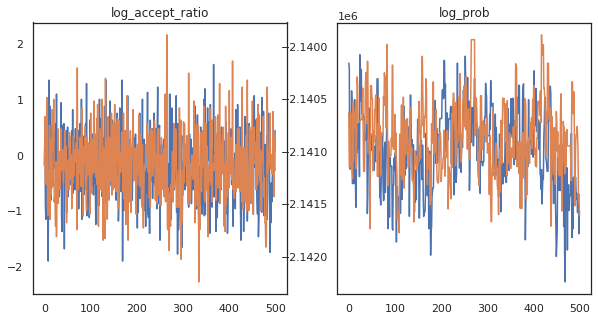

In [ ]:
fig, axs = plt.subplots(1, len(trace), figsize=(5 * len(trace), 5))
for ax, (key, val) in zip(axs, trace.items()):
  ax.plot(val[0]) # Indexing into a sharded array, each element is the same
  ax.set_title(key);

现在我们有了马尔科夫链的一些样本，让我们使用它们来做一些预测。首先，我们提取每个组件。请记住，`user_embeddings` 和 `user_bias` 是跨设备分割的，因此我们需要串联 `ShardedArray` 来获得它们。另一方面，`movie_embeddings` 和 `movie_bias` 在每个设备上都是相同的，因此我们可以选择第一个分片中的值。我们将使用常规 `numpy` 将 TPU 中的值复制回 CPU。

In [ ]:
user_embeddings = np.concatenate(np.array(states.user_embeddings, np.float32), axis=2)
user_bias = np.concatenate(np.array(states.user_bias, np.float32), axis=2)
movie_embeddings = np.array(states.movie_embeddings[0], dtype=np.float32)
movie_bias = np.array(states.movie_bias[0], dtype=np.float32)
samples = (user_embeddings, user_bias, movie_embeddings, movie_bias)
print(f'User embeddings: {user_embeddings.shape}')
print(f'User bias: {user_bias.shape}')
print(f'Movie embeddings: {movie_embeddings.shape}')
print(f'Movie bias: {movie_bias.shape}')

User embeddings: (500, 2, 6040, 20)
User bias: (500, 2, 6040)
Movie embeddings: (500, 2, 3706, 20)
Movie bias: (500, 2, 3706)


让我们尝试构建一个简单的推荐系统，利用这些样本中捕获的不确定性。我们先编写一个根据观看概率对电影进行排名的函数。

In [ ]:
@jax.jit
def recommend(sample, user_id):
  user_embeddings, user_bias, movie_embeddings, movie_bias = sample
  movie_logits = (
      jnp.einsum('d,md->m', user_embeddings[user_id], movie_embeddings)
      + user_bias[user_id] + movie_bias)
  return movie_logits.argsort()[::-1]

我们现在可以编写一个函数来循环遍历所有样本，选择用户尚未观看的排名最高的电影。然后我们可以查看根据样本推荐的所有电影的数量。

In [ ]:
def get_recommendations(user_id): 
  movie_ids = []
  already_watched = set(jnp.arange(num_movies)[watch_matrix[user_id] == 1])
  for i in range(500):
    for j in range(2):
      sample = jax.tree_map(lambda x: x[i, j], samples)
      ranking = recommend(sample, user_id)
      for movie_id in ranking:
        if int(movie_id) not in already_watched:
          movie_ids.append(movie_id)
          break
  return movie_ids

def plot_recommendations(movie_ids, ax=None):
  titles = collections.Counter([movie_id_to_title[i] for i in movie_ids])
  ax = ax or plt.gca()
  names, counts = zip(*sorted(titles.items(), key=lambda x: -x[1]))
  ax.bar(names, counts)
  ax.set_xticklabels(names, rotation=90)

让我们将看过最多电影的用户和看过最少电影的用户进行比较。

In [ ]:
user_watch_counts = watch_matrix.sum(axis=1)
user_most = user_watch_counts.argmax()
user_least = user_watch_counts.argmin()
print(user_watch_counts[user_most], user_watch_counts[user_least])

2314 20


考虑到我们有更多关于 `user_most` 更有可能观看哪类电影的信息，我们希望系统的 `user_most` 比 `user_least` 更具确定性。

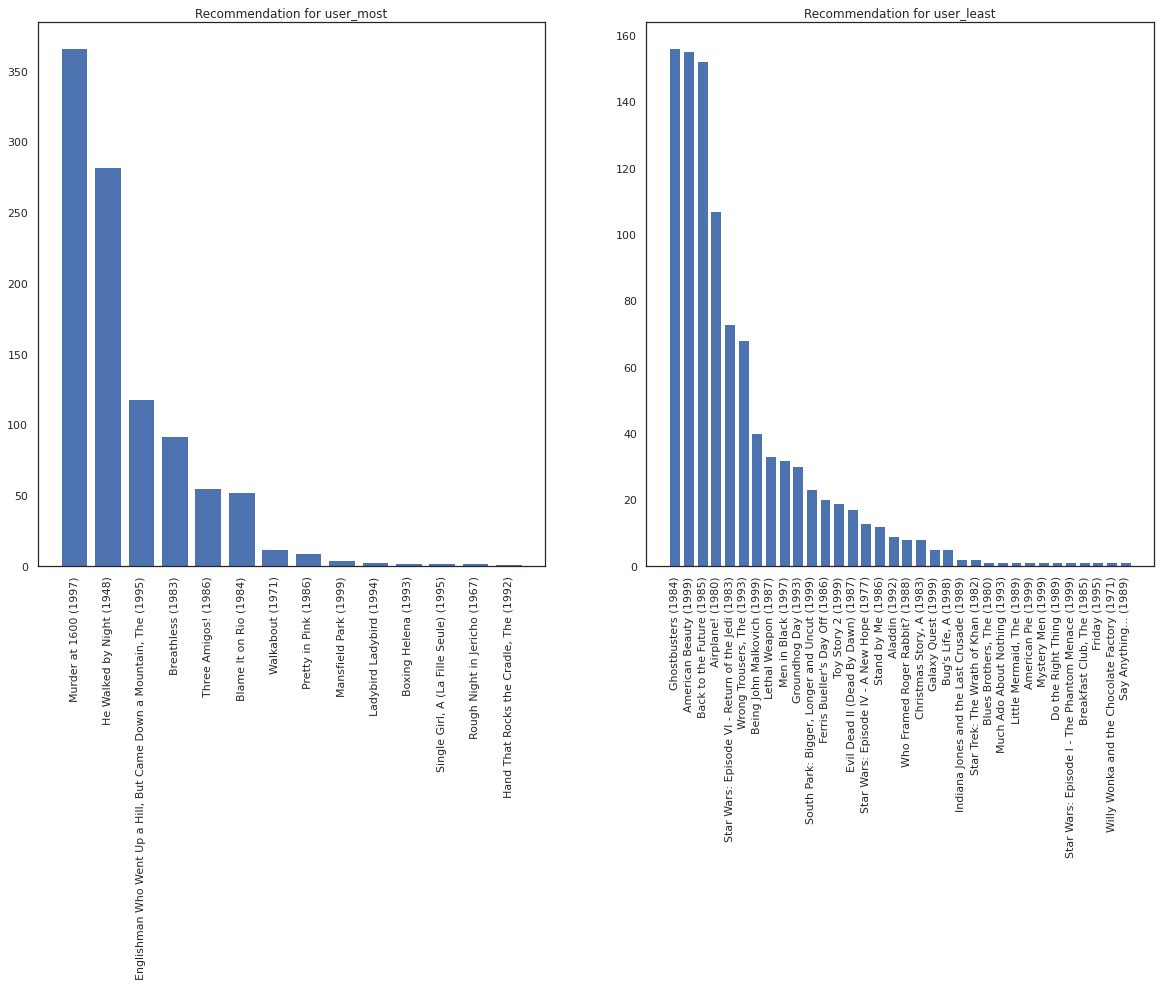

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
most_recommendations = get_recommendations(user_most)
plot_recommendations(most_recommendations, ax=ax[0])
ax[0].set_title('Recommendation for user_most')
least_recommendations = get_recommendations(user_least)
plot_recommendations(least_recommendations, ax=ax[1])
ax[1].set_title('Recommendation for user_least');

我们看到，我们对 `user_least` 的推荐存在更多差异，这反映了我们对他们的观看偏好有额外的不确定性。

我们还可以查看推荐的电影的类型。

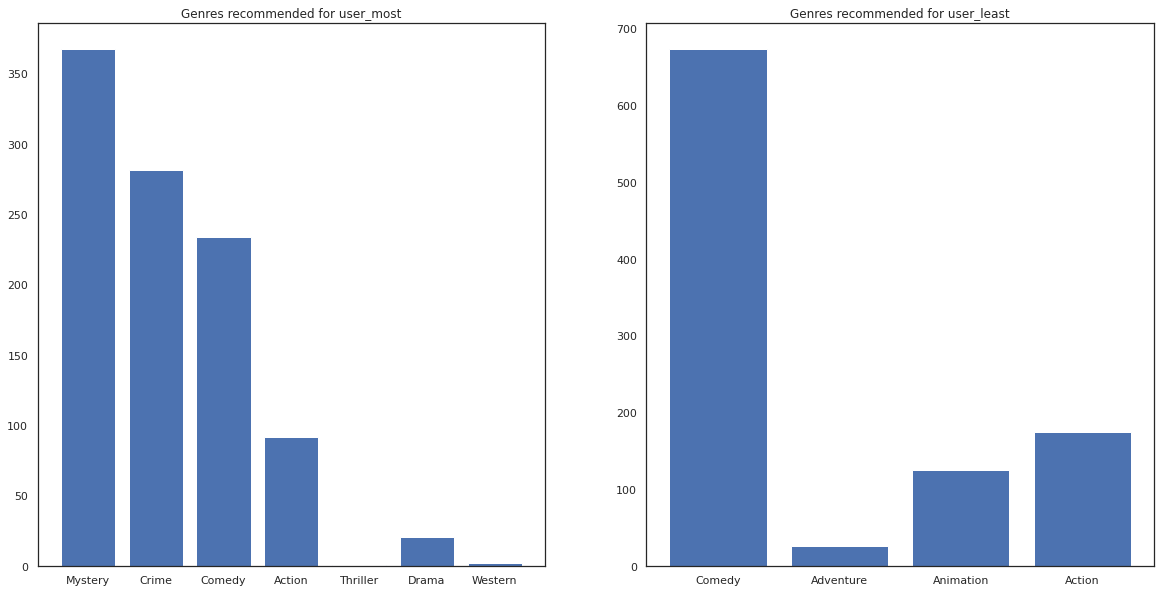

In [ ]:
most_genres = collections.Counter([movie_id_to_genre[i] for i in most_recommendations])
least_genres = collections.Counter([movie_id_to_genre[i] for i in least_recommendations])
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].bar(most_genres.keys(), most_genres.values())
ax[0].set_title('Genres recommended for user_most')
ax[1].bar(least_genres.keys(), least_genres.values())
ax[1].set_title('Genres recommended for user_least');

`user_most` 看过许多电影，因此被推荐了更小众的类型，如悬疑片和犯罪片，而 `user_least` 没有看过很多电影，因此被推荐了更多主流电影，偏向喜剧片和动作片。